**Set environment**

In [1]:
suppressMessages(suppressWarnings(source("../config/config_sing.R")))
show_env()

You are in Singularity: singularity_proj_encode_fcc 
BASE DIRECTORY (FD_BASE): /data/reddylab/Kuei 
WORK DIRECTORY (FD_WORK): /data/reddylab/Kuei/out 
CODE DIRECTORY (FD_CODE): /data/reddylab/Kuei/code 
PATH OF PROJECT (FD_PRJ): /data/reddylab/Kuei/code/Proj_CombEffect_ENCODE_FCC 
PATH OF RESULTS (FD_RES): /data/reddylab/Kuei/out/proj_combeffect_encode_fcc 
PATH OF LOG     (FD_LOG): /data/reddylab/Kuei/out/proj_combeffect_encode_fcc/log 


## Import data

In [2]:
ASSAY   = "CRISPRi_FlowFISH"
FOLDER  = "coverage_astarrseq_peak_macs_input"

fdiry = file.path(FD_RES, "results", ASSAY, FOLDER)
fname = "Merge_HCRFF_rAVG.log2FC_2.filtered.bed.gz"
fpath = file.path(fdiry, fname)

cnames = c(
    "Chrom_Peak",  "Start_Peak",  "End_Peak",
    "Chrom_Guide", "Start_Guide", "End_Guide", "Guide_ID", "Score", "Gene", 
    "Overlap"
)
dat = read_tsv(fpath, col_names = cnames, show_col_types = FALSE)

dat_peak_score_import = dat
print(dim(dat))
head(dat)

[1] 176457     10


Chrom_Peak,Start_Peak,End_Peak,Chrom_Guide,Start_Guide,End_Guide,Guide_ID,Score,Gene,Overlap
<chr>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<chr>,<dbl>,<chr>,<dbl>
chr11,4092104,4092566,chr11,4092122,4092123,id-145,-1.101030,HBE1,1
chr11,4092104,4092566,chr11,4092123,4092124,id-146,-0.061961,HBE1,1
chr11,4092104,4092566,chr11,4092130,4092131,id-147,0.528464,HBE1,1
chr11,4092104,4092566,chr11,4092135,4092136,id-148,0.497477,HBE1,1
chr11,4092104,4092566,chr11,4092162,4092163,id-149,-0.190223,HBE1,1
chr11,4092104,4092566,chr11,4092163,4092164,id-150,-1.781920,HBE1,1


**Check results**

In [3]:
### overlap should be all one
table(dat_peak_score_import$Overlap)


     1 
176457 

## Arrange

In [4]:
dat = dat_peak_score_import
dat = dat %>% 
    dplyr::mutate(
        Peak  = paste0(Chrom_Peak, ":",  Start_Peak, "-", End_Peak),
        Guide = paste0(Chrom_Guide,":", Start_Guide, "-", End_Guide)) %>%
    dplyr::select(
        Peak, Guide, Gene, Score
    )

###
dat_peak_score_arrange = dat
print(dim(dat))
head(dat)

[1] 176457      4


Peak,Guide,Gene,Score
<chr>,<chr>,<chr>,<dbl>
chr11:4092104-4092566,chr11:4092122-4092123,HBE1,-1.101030
chr11:4092104-4092566,chr11:4092123-4092124,HBE1,-0.061961
chr11:4092104-4092566,chr11:4092130-4092131,HBE1,0.528464
chr11:4092104-4092566,chr11:4092135-4092136,HBE1,0.497477
chr11:4092104-4092566,chr11:4092162-4092163,HBE1,-0.190223
chr11:4092104-4092566,chr11:4092163-4092164,HBE1,-1.781920


## Summary

In [5]:
###
dat = dat_peak_score_arrange
dat = dat %>% dplyr::mutate(Sign  = ifelse(Score > 0, "pos", "neg"))

###
dat_summary_total = dat %>%
    dplyr::group_by(Peak, Gene) %>%
    dplyr::summarise(
        Mean    = mean(Score),
        Median  = median(Score),
        Max     = max(Score),
        Min     = min(Score),
        Count   = n(),
        .groups = "drop"
    )

###
dat_summary_sign = dat %>%
    dplyr::group_by(Peak, Gene, Sign) %>%
    dplyr::summarise(Mean = mean(Score), .groups = "drop") %>% 
    dplyr::mutate(Sign = dplyr::recode(Sign, `pos` = "Mean_Pos", `neg` = "Mean_Neg")) %>% 
    tidyr::spread(Sign, Mean)

###
dat = dplyr::left_join(
    dat_summary_total,
    dat_summary_sign,
    by = c("Peak", "Gene")) %>% 
    replace(is.na(.), 0)

dat_peak_score_summary = dat
print(dim(dat))
head(dat)

[1] 3084    9


Peak,Gene,Mean,Median,Max,Min,Count,Mean_Neg,Mean_Pos
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>
chr11:33065336-33066228,CAPRIN1,-0.27343935,-0.2533300,1.82911,-2.32196,46,-0.5695431,0.4782085
chr11:33065336-33066228,CAT,-0.01256696,-0.1384765,1.43868,-1.77410,46,-0.5122241,0.6369873
chr11:33065336-33066228,LMO2,0.03675483,-0.0071000,1.09905,-1.14702,46,-0.4276747,0.5011843
chr11:33068519-33069100,CAPRIN1,-0.11785479,-0.0847600,1.64429,-2.01338,53,-0.4252182,0.4797963
chr11:33068519-33069100,CAT,-0.15932204,-0.1697360,2.12211,-2.59035,53,-0.6266582,0.6769637
chr11:33068519-33069100,LMO2,-0.08303026,-0.1090310,2.73010,-2.25265,53,-0.5389359,0.5116293


In [7]:
dat = dat_peak_score_summary
dat = dat %>% 
    dplyr::group_by(Peak) %>%
    dplyr::summarize(
        Mean_Tot = mean(Mean),
        Mean_Pos = max(Mean, 0),
        Mean_Neg = min(Mean, 0),
        Count    = sum(Count),
        Note     = paste(Gene, Count, sep=":", collapse="|"),
        .groups  = "drop"
    ) %>%
    dplyr::rename("Mean" = "Mean_Tot")

dat_peak_score_summary_merge = dat
print(dim(dat))
head(dat)

[1] 1330    6


Peak,Mean,Mean_Pos,Mean_Neg,Count,Note
<chr>,<dbl>,<dbl>,<dbl>,<int>,<chr>
chr11:33065336-33066228,-0.08308383,0.03675483,-0.2734393,138,CAPRIN1:138|CAT:138|LMO2:138
chr11:33068519-33069100,-0.12006903,0.00000000,-0.1593220,159,CAPRIN1:159|CAT:159|LMO2:159
chr11:33072412-33072630,0.10643558,0.35299267,-0.1982723,36,CAPRIN1:36|CAT:36|LMO2:36
chr11:33103533-33104120,0.98158422,1.44209600,0.0000000,9,CAPRIN1:9|CAT:9|LMO2:9
chr11:33114629-33115134,0.22095793,0.42649733,0.0000000,27,CAPRIN1:27|CAT:27|LMO2:27
chr11:33125296-33126416,-0.05128921,0.04323581,-0.1542515,159,CAPRIN1:159|CAT:159|LMO2:159


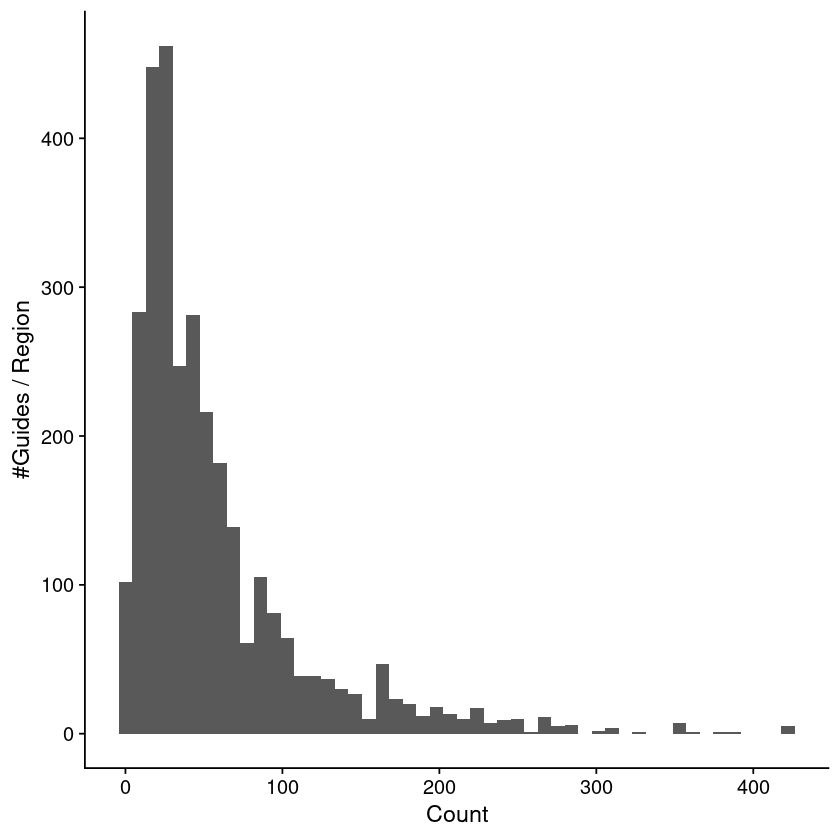

In [8]:
dat = dat_peak_score_summary
gpt = ggplot(dat, aes(x=Count)) + 
    geom_histogram(bins = 50) + 
    labs(y="#Guides / Region") +
    theme_cowplot()
print(gpt)

## Save results

In [9]:
fdiry = file.path(FD_RES, "results", ASSAY, FOLDER, "summary")
fname = "results.score.tsv"
fpath = file.path(fdiry, fname)

dat = dat_peak_score_arrange
write_tsv(dat, fpath)

In [10]:
fdiry = file.path(FD_RES, "results", ASSAY, FOLDER, "summary")
fname = "results.summary.tsv"
fpath = file.path(fdiry, fname)

dat = dat_peak_score_summary
write_tsv(dat, fpath)

In [11]:
fdiry = file.path(FD_RES, "results", ASSAY, FOLDER, "summary")
fname = "results.summary.Merge.tsv"
fpath = file.path(fdiry, fname)

dat = dat_peak_score_summary_merge
write_tsv(dat, fpath)